# Roman, Rubin SN Simulation modeling with AstroPhot

Author: Michael Wood-Vasey <wmwv@pitt.edu>  
Last Verified to run: 2024-02-29

Use the [AstroPhot](https://autostronomy.github.io/AstroPhot/) package to model lightcurve of SN in Roman HLTDS [Supernova Survey](https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.3874W)
or Rubin LSST [LSST DESC DC2](https://data.lsstdesc.org/doc/dc2_sim_sky_survey) simulations.

Notable Requirements:  
astrophot  
astropy  
torch  

Major TODOs:
  * [~] Get calibrated zeropoints for Roman sims and make sure they're correct for the given PSF (i.e., aperture corrections).
  * [~] Implement SIP WCS in AstroPhot to deal with slight variation in object positions
    - Instead implemented a per-image (but not per object) astrometric shift.

## Environment

This Notebook was developed and tested within a conda environment.  You can create this environment with:

```
conda create --name astrophot -c conda-forge python=3.11 astropy cudatoolkit h5py  ipykernel jupyter matplotlib numpy pandas pyyaml pyarrow scipy requests tqdm 
conda activate astrophot
pip install astrophot pyro-ppl torch
ipython kernel install --user --name=astrophot
```

## Data

This tutorial presents two options for datasets: "DC2" and "RomanSN".  The datasets were chosen because they were of interest to the primary author of this tutorial (MWV).  Unfortunately, there's just a bit of work to download the data.  For the Roman SN simulations, the extra work is that you need to download the full image focal planes, even when we're just using one detector from each image (out of 18 detectors total).  For the Rubin LSST DESC DC2 simulations, the extra work is using either Globus to download the data from the [DESC Data Archive](https://data.lsstdesc.org/doc/download), or using the [Rubin Science Pipelines DP0.2](https://data.lsst.cloud) to download the data through the Portal or API interfaces.

In [1]:
# Select `DATASET` as either "DC2" or "RomanSN"
# DATASET = "DC2"
DATASET = "RomanSN"

### LSST DESC Data Challenge 2 Data

The first data set use data from the LSST DESC DC2 simulated data set as processed by the LSST Science Pipelines for Data Preview 0.2.

https://arxiv.org/abs/2101.04855  
https://ui.adsabs.harvard.edu/abs/2021ApJS..253...31L.


Option 1: Access to the DESC DC2 through the [DESC Data Archive](https://data.lsstdesc.org/doc/download) requires creating a Globus account and having a Globus end point whereever you want to put the data.  Then GUI selection of the datasets you want to download.

Option 2: Access to the Rubin-processed DP0.2 data requires [registering to be a DP0 Delegate](https://dp0-2.lsst.io/dp0-delegate-resources/index.html#) and being an LSST Data Rights Holder.

This tutorial was written using data that were downloaded through the https://data.lsst.cloud Portal as the g-, r-, and i-band images overlapping the position of a supernova simulated in the DC2 data: ICRS (RA, Dec): (60.2901401, -44.142051) degrees during the 2025-08-01 through 2025-12-31.

This tutorials assumes that the DC2 image files will be placed into:
DATADIR = "data/DC2"

The DC2 tables of simulated SNe, can be downloaded via Globus at:

https://data.lsstdesc.org/browse/dataset/4dab60f0-1b22-4304-b01d-519311783c4c

### Roman HLTDS Data

The other data set uses data from Roman simulations of SN in 
"A synthetic Roman Space Telescope High-Latitude Time-Domain Survey: supernovae in the deep field"
Wang et al. 2023, MNRAS, 523, 3, 3874.
https://ui.adsabs.harvard.edu/abs/2023MNRAS.523.3874W

Data page
https://roman.ipac.caltech.edu/sims/SN_Survey_Image_sim.html

We're here trying out 3 images selected by Lauren Aldoroty that have a SN.  You could download them here with the following bash script: 

Note that this scripts work, but gets you much more data than we needed. The three images are 1.3 GB each, covering the 18 detectors for the Roman WFI instrument.  We only need one, but the tarballs are for the full focal plane.  The rotate_Y_truth catalog is 288 MB.  The remaining catalog files are much smaller.

```
DATADIR=data/RomanSN
mkdir -p ${DATADIR}
curl "https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_update_Y106_132.tar.gz" --output ${DATADIR}/rotate_update_Y106_132.tar.gz
curl "https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_update_Y106_160.tar.gz" --output ${DATADIR}/rotate_update_Y106_160.tar.gz
curl "https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_update_Y106_170.tar.gz" --output ${DATADIR}/rotate_update_Y106_170.tar.gz

# SN input catalog / SN
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/WFIRST_AKARI_FIXED_HEAD.FITS --output ${DATADIR}/WFIRST_AKARI_FIXED_HEAD.FITS

# SN input lightcurves
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/WFIRST_AKARI_FIXED_PHOT.FITS.gz --output ${DATADIR}/WFIRST_AKARI_FIXED_PHOT.FITS.gz

# SN truth
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/rotate_Y_truth.tar.gz --output ${DATADIR}/rotate_Y_truth.tar.gz

# Image Metadata
curl https://roman.ipac.caltech.edu/data/sims/sn_image_sims/paper_rotate.fits --output ${DATADIR}/paper_rotate.fits

cd data; (for f in rotate_update_Y106_*.tar.gz; do tar xvzf $f "*_1.fits.gz"; done); gunzip *.fits.gz; cd -
```


If you like you can view the FITS files and the SN region file (see below) with
```
ds9 data/rotate_update_Y106_132_1.fits data/rotate_update_Y106_174_1.fits data/rotate_update_Y106_175_1.fits -region load all sn.reg -scale mode zscale -scale match -frame lock wcs -zoom to fit
```

In [2]:
import os
import re
from typing import Optional

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import iqr

import pandas as pd
import torch

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.wcs import WCS

import astrophot as ap
from astrophot.image import PSF_Image, Window

### SN and Host position

In [3]:
if DATASET == "DC2":
    # DC2
    # fitting window will be a npix x npix box
    npix_dict = {41021613806: 100,
                 11392192729110: 75}

    sn_dict = {
        41021613806: {"ra": 60.2901401, "dec": -44.142051},
        11392192729110: {"ra": 60.1996112, "dec": -44.2708990},
    }
    host_dict = {
        41021613806: {"ra": 60.288242, "dec": -44.139890},
        11392192729110: {"ra": 60.1996379, "dec": -44.2705822},
    }

    # MJD that is clearly before the explosion date
    mjd_before_sn = {41021613806: 60930, 11392192729110: 60985}

    sn_id = 11392192729110
#    sn_id = 41021613806
    sn = sn_dict[sn_id]
    host = host_dict[sn_id]
    npix = npix_dict[sn_id]

elif DATASET == "RomanSN":
    # RomanSN
    sn = {"ra": 71.30192566051916, "dec": -53.60051728973533}
    sn_id = 15288
    # We don't have a separate galaxy position here
    host_id = 893893
    # The file lists these separately, but these are actually the same position
    # better than 0.1 milliarcsec.
    host = {"ra": 71.30192565917969, "dec": -53.60051727294922}
    mjd_before_sn = {15288: 55220}
    
    npix = 50  # window will be a npix x npix box

In [4]:
sn_coord = SkyCoord(sn["ra"], sn["dec"], unit=u.degree)

### Data files

In [5]:
if DATASET == "DC2":
    data_dir = "data/DC2"

    image_file_basenames_dict = {
        41021613806: [
            "image_calexp-g-944022-R43_S11-2025-10-14T04.fits",
            "image_calexp-g-944052-R31_S12-2025-10-14T04.fits",
            "image_calexp-g-944236-R31_S11-2025-10-14T06.fits",
            "image_calexp-g-960109-R03_S21-2025-11-14T01.fits",
            "image_calexp-g-975987-R43_S01-2025-12-08T02.fits",
            "image_calexp-r-909835-R30_S01-2025-08-18T07.fits",
            "image_calexp-r-909869-R31_S10-2025-08-18T08.fits",
            "image_calexp-r-909956-R01_S02-2025-08-18T09.fits",
            "image_calexp-r-910001-R12_S10-2025-08-18T09.fits",
            "image_calexp-r-942690-R02_S11-2025-10-12T08.fits",
            "image_calexp-r-942722-R23_S10-2025-10-12T08.fits",
            "image_calexp-r-943370-R24_S12-2025-10-13T06.fits",
            "image_calexp-r-943372-R22_S00-2025-10-13T06.fits",
            "image_calexp-r-943428-R01_S22-2025-10-13T07.fits",
            "image_calexp-r-963953-R21_S02-2025-11-19T02.fits",
            "image_calexp-r-963987-R32_S20-2025-11-19T02.fits",
            "image_calexp-r-964110-R03_S22-2025-11-19T04.fits",
            "image_calexp-r-969979-R34_S10-2025-11-28T04.fits",
            "image_calexp-r-970022-R24_S10-2025-11-28T04.fits",
            "image_calexp-i-915668-R24_S22-2025-08-25T07.fits",
            "image_calexp-i-915698-R01_S11-2025-08-25T07.fits",
            "image_calexp-i-924121-R20_S20-2025-09-19T06.fits",
            "image_calexp-i-934006-R31_S02-2025-10-01T06.fits",
            "image_calexp-i-934015-R20_S12-2025-10-01T06.fits",
            "image_calexp-i-941091-R11_S02-2025-10-10T08.fits",
            "image_calexp-i-945601-R10_S12-2025-10-16T03.fits",
            "image_calexp-i-966789-R01_S02-2025-11-24T01.fits",
            "image_calexp-i-966821-R23_S10-2025-11-24T01.fits",
            "image_calexp-i-966822-R24_S00-2025-11-24T01.fits",
            "image_calexp-i-976120-R10_S11-2025-12-08T03.fits",
            "image_calexp-i-976272-R33_S22-2025-12-08T05.fits",
            "image_calexp-i-976304-R41_S00-2025-12-08T05.fits",
            "image_calexp-i-976336-R23_S20-2025-12-08T06.fits",
        ],
        11392192729110: [
            "image_calexp-i-915668-R24_S12-2025-08-25T07.fits",
            "image_calexp-i-924121-R20_S11-2025-09-19T06.fits",
            "image_calexp-i-934006-R21_S22-2025-10-01T06.fits",
            "image_calexp-i-941052-R34_S12-2025-10-10T08.fits",
            "image_calexp-i-941091-R11_S02-2025-10-10T08.fits",
            "image_calexp-i-945573-R01_S02-2025-10-16T03.fits",
            "image_calexp-i-945601-R10_S22-2025-10-16T03.fits",
            "image_calexp-i-976272-R33_S22-2025-12-08T05.fits",
            "image_calexp-r-896748-R14_S20-2025-08-03T08.fits",
            "image_calexp-r-909835-R30_S01-2025-08-18T07.fits",
            "image_calexp-r-963953-R21_S02-2025-11-19T02.fits",
            "image_calexp-r-964110-R03_S22-2025-11-19T04.fits",
            "image_calexp-r-969979-R34_S10-2025-11-28T04.fits",
            "image_calexp-r-970022-R24_S10-2025-11-28T04.fits",
        ],
    }
    image_file_basenames = image_file_basenames_dict[sn_id]

    select_filter = re.compile("image_calexp-([a-zA-Z0-9]+)-")
    band = [select_filter.match(f).groups()[0] for f in image_file_basenames]
    select_visit = re.compile("image_calexp-[a-z]-([0-9]+)-")
    visit = [int(select_visit.match(f).groups()[0]) for f in image_file_basenames]

elif DATASET == "RomanSN":
    data_dir = "data/RomanSN"

    # The metadata for the files is stored by row idx that is encoded in the filename
    # We'll use that later to look up the information for the file.
    image_info_row = [132, 160, 170]
    band = ["Y"] * len(image_info_row)
    full_band_name = {"Y": "Y106"}
    
    detectors = [1, 10, 1]
    image_file_basenames = [
        f"rotate_update_{full_band_name[b]}_{idx}_{det}.fits"
        for b, idx, det in zip(band, image_info_row, detectors)
    ]

    visit = image_info_row  # No defined visit so we'll take image row

else:
    print(f"Unsupported DATASET: {DATASET}")

In [6]:
image_files = [os.path.join(data_dir, bn) for bn in image_file_basenames]

Get the PSF from the calexp PSFEx model

In [7]:
def resample_psf_2x2(psf):
    nx, ny = psf.shape
    
    # If odd, then we want to preserve the center row nx//2, nx//2
    # And we'll average the other rows together, 2 at a time

    # Rows
    # nx = 40
    # 0:20, 40-20:40
    # 
    a = psf[:nx//2, :].reshape(nx//4, 2, ny).sum(axis=1) / 2
    b = psf[-(nx-1)//2:, :].reshape(nx//4, 2, ny).sum(axis=1) / 2
    if nx % 2 == 1:
        x_pieces = [a, psf[nx//2:nx//2+1, :], b]
    else:
        x_pieces = [a, b]
    c = np.concatenate(x_pieces, axis=0)
    
    # Columns
    d = c[:, :ny//2].reshape((nx+1)//2, ny//4, 2).sum(axis=2) / 2
    e = c[:, -(ny-1)//2:].reshape((nx+1)//2, ny//4, 2).sum(axis=2) / 2
    if ny % 2 == 1:
        y_pieces = [d, c[:, ny//2:ny//2+1], e]
    else:
        y_pieces = [d, e]
    new_psf = np.concatenate(y_pieces, axis=1)
    
    return new_psf

In [8]:
def test_resample_psf_2x2_odd():
    test_array_odd = np.zeros((81, 81))
    smaller_test_array_odd = resample_psf_2x2(test_array_odd)
    assert np.shape(smaller_test_array_odd) == (41, 41)

def test_resample_psf_2x2_even():
    test_array_even = np.zeros((40, 40))
    smaller_test_array_even = resample_psf_2x2(test_array_even)
    assert np.shape(smaller_test_array_even) == (20, 20)

In [9]:
test_resample_psf_2x2_odd()

In [10]:
test_resample_psf_2x2_even()

In [11]:
def read_psfex_image(psfex_info, psfex_data, resample=True, non_negative=True):
    """
    Reads the PSFex header extensions from the LSST Science Pipelines.

    Returns:
    --------
    pixstep: float, arcsec/pixel (assumed symmetric and scalar)
    psf_image: [n, n]

    Notes:
    ------
    Used for DC2 DP0.2 processing.  This is not documented behavior and
    is not robust against future changes.
    
    But you may find that you have an equivalent "get the PSF" function
    for the dataset of interest to you.
    """
    size = psfex_data.data["_size"]
    comp = psfex_data.data["_comp"]

    psf_basis_image = comp.reshape(*size[0][::-1])

    # The PSF is oversampled by pixstep
    pixstep = psfex_info.data._pixstep[0]

    # Calculate the PSF at the location of the reference X, Y points on the image.
    psf_image = psf_basis_image * psfex_data.data["basis"][0, :, np.newaxis, np.newaxis]
    psf_image = psf_image.sum(0)

    if resample:
        # Hardcoded 2x2 resampling
        psf_image = resample_psf_2x2(psf_image)
        pixstep *= 2

    if non_negative:
        psf_image[np.nonzero(psf_image < 0)] = 0

    # Tensor expects float64
    psf_image = psf_image.astype("float64")

    # And normalize to 1 over the PSF area, but in image pixel space
    psf_image /= psf_image.sum() * pixstep**2

    return pixstep, psf_image

In [12]:
def calc_fwhm_from_psf_image(image):
    nx, ny = np.shape(image)

    x, y = np.meshgrid(np.arange(nx) - nx//2, np.arange(ny) - ny//2)

    norm = np.sum(image)

    # Calculate first moment
    x_center = np.sum(image * x**1) / norm
    y_center = np.sum(image * y**1) / norm

    # Calculate second moments
    I_xx = (np.sum(image * (x-x_center)**2 * (y-y_center)**0) / norm)
    I_xy = (np.sum(image * (x-x_center)**1 * (y-y_center)**1) / norm)
    I_yy = (np.sum(image * (x-x_center)**0 * (y-y_center)**2) / norm)

    fwhm = np.sqrt(I_xx + I_yy)
 
    return fwhm

In [13]:
if DATASET == "DC2":
    f = image_files[0]
    hdu = fits.open(f)

    pixstep, psf = read_psfex_image(hdu[11], hdu[12], resample=False)
    fwhm = calc_fwhm_from_psf_image(psf) * pixstep
    print(f"FWHM={fwhm:0.4f} pixels")

    plt.imshow(psf[:, :], cmap="rainbow")
    plt.colorbar()

## Roman PSF

The Roman Wide-Field Imager (WFI) PSF is available in detail through the `webbpsf` package.  But to simplify requirements for this tutorial (which are already pretty significant in the data), we will used a simplified pre-stored model of the PSF.  This model was generated with the following code:

```
import webbpsf

wfi = webbpsf.roman.WFI()
wfi.filter = "F106"
default_psf = wfi.calc_psf(outfile="roman_psf_nominal.fits")
```

For more information about Roman PSFs for the Wide-Field Imager, see

https://roman-docs.stsci.edu/simulation-tools-handbook-home/webbpsf-for-roman/webbpsf-tutorials
https://github.com/spacetelescope/webbpsf/blob/develop/notebooks/WebbPSF-Roman_Tutorial.ipynb

For actual usage, you should calculate the PSF for the specific observation, including detector (SCA).  Most notably, there is spatial variation of the PSF, and different roll angles will put the diffraction spikes in different places.  But we're just using simple approximations for now.

In [14]:
if DATASET == "RomanSN":
    with fits.open("roman_psf_nominal.fits") as hdu:
        pixstep = hdu["OVERSAMP"].header["PIXELSCL"]
        psf = hdu["OVERSAMP"]

### Detector, Image, and FITS file order

In [15]:
# These are 4k x 4k images
pixel_scale = {"DC2": 0.2, "RomanSN": 0.11}  # "/pixel
fwhm = {"DC2": 0.6, "RomanSN": 0.2}  # "

# The HDU order is different between the two datasets
HDU_IDX = {
    "DC2": {"image": 1, "mask": 2, "variance": 3, "psfex_info": 11, "psfex_data": 12},
    "RomanSN": {"image": 1, "mask": 3, "variance": 2},
}
# as are the FITS extension names
HDU_NAMES = {
    "DC2": {"image": "image", "mask": "mask", "variance": "variance"},
    "RomanSN": {"image": "SCI", "mask": "DQ", "variance": "ERR"},
}
# so we have to use a translation regardless.

# But the variance plane for the Roman images isn't actually right
# So we use the Image plane for the variance.
HDU_IDX["RomanSN"]["variance"] = HDU_IDX["RomanSN"]["image"]
HDU_NAMES["RomanSN"]["variance"] = HDU_NAMES["RomanSN"]["image"]

In [16]:
### Bad pixel mask values
bad_pixel_bitmask = {}

## DC2
# Pixel mask values are defined in
# https://github.com/lsst/afw/blob/29afe694f19d80cba34b10ffd361dc6ca8d49dd1/src/image/detail/MaskDict.cc#L206
# The "right" way is to use `getMaskPlaneDict` in the LSST Science Pipelines
# but we don't want to introduce that dependency here.

# "EDGE": 4 is not necessarily bad, although it could be a cause for concern we'll accept it for now
# "DETECTED": 5 and "DETECTED_NEGATIVE": 6 are both bits indicating detection of objects
# and are not "bad"
basic_mask_plane_bits = {
    "BAD": 0,
    "SAT": 1,
    "INTRP": 2,
    "CR": 3,
    "SUSPECT": 7,
    "NO_DATA": 8,
}
bad_pixel_bitmask["DC2"] = sum(
    2 ** np.array([v for v in basic_mask_plane_bits.values()])
)

## Roman
bad_pixel_bitmask["RomanSN"] = 0b1

### Image metadata table

If you have the information, create a image metadata table here called `image_metadata`.  It will be used below to add key information to the AstroPhot target header metadata and which will in turn be used to build the lightcurve table for the photometry.  The table should have rows in the same order as the `image_file_basenames` (and `image_files`) arrays.  It is expected to have "mjd" and "band".

#### DC2
For DC2, the DATE-START, DATE-END, and DATA-AVG are stored in the header.  So we get the MJD by reading the headers and translate DATE-AVG to MJD.

The SN lightcurve truth values are stored in `truth_sn_variability_v1-0-0.parquet`, which includes a row for each simulated SN lightcurve point.

#### RomanSN
For Roman SN simulation, the dates are stored in a separate file: `paper_rotate.fits`.  We look up the MJD from appropriate row using the index in the simulated filename.

For the SN truth values, we start with `WFIRST_AKARI_FIXED_HEAD.FITS` that contains a line for each SN.  That line includes the starting and ending indexes for the entries in `WFIRST_AKARI_FIXED_PHOT.FITS`.  However, those indexes seem are off-by-one.  E.g., PTROBS_MIN, PTROBS_MAX are 1, 144 for the first entry; 146, 317 for the second; and 319, 486 for the third.  There is then an extra line in between each set of lightcurves -- this line is marked with an MJD of `-777.` and a FIELD of `"XXXX"`.  

In [17]:
lightcurve_truth = None

zp_AB_to_nJy = 8.90 + 2.5 * 9


if DATASET == "DC2":
    mjd = []
    for f in image_files:
        header = fits.getheader(f)
        dt = Time(header["DATE-AVG"], scale=header["TIMESYS"].lower())
        mjd.append(dt.mjd)

    summary_file = os.path.join(data_dir, "truth_sn_summary_v1-0-0.parquet")
    variability_file = os.path.join(data_dir, "truth_sn_variability_v1-0-0.parquet")

    df = pd.read_parquet(variability_file)
    lightcurve_truth = df[df["id"] == sn_id]

    lightcurve_truth = Table.from_pandas(lightcurve_truth)

    lightcurve_truth["flux"] = lightcurve_truth["delta_flux"]
    lightcurve_truth["mag"] = (
        -2.5 * np.log10(lightcurve_truth["delta_flux"]) + zp_AB_to_nJy
    )
    lightcurve_truth["band"] = lightcurve_truth["bandpass"]
    lightcurve_truth["visit"] = lightcurve_truth["obsHistID"]

elif DATASET == "RomanSN":
    image_metadata_basename = "paper_rotate.fits"
    image_metadata_filename = os.path.join(data_dir, image_metadata_basename)
    image_metadata = Table.read(image_metadata_filename)

    mjd = image_metadata[image_info_row]["date"]
    visit = np.array(mjd, dtype=int)

    summary_file = os.path.join(data_dir, "WFIRST_AKARI_FIXED_HEAD.FITS")
    variability_file = os.path.join(data_dir, "WFIRST_AKARI_FIXED_PHOT.FITS")

    data = fits.getdata(summary_file, 1)
    # The SNIDs are stored as str in the summary file
    lightcurve_truth_summary = Table(data[data["SNID"] == str(sn_id)])
    # Adjust by -1 because they PTR* are 1-indexed
    start = lightcurve_truth_summary["PTROBS_MIN"].value[0] - 1
    end = lightcurve_truth_summary["PTROBS_MAX"].value[0] - 1

    var_df = Table(fits.getdata(variability_file, 1))
    lightcurve_truth = var_df[start:end]

    # "FLUXCAL" is flux after SNANA adds noise, but this is not what was fed to the simulations
    # "SIM_MAGOBS" is magnitude before noise is added
    # The effective ZP to convert between SIM_MAGOBS and FLUXCAL is 27.5 mag.
    # We'll here define the truth flux using the SIM_MAGOBS and instead the zp_AB_to_nJY zeropoint.
    lightcurve_truth["flux"] = 10 ** (
        -0.4 * (lightcurve_truth["SIM_MAGOBS"] - zp_AB_to_nJy)
    )
    lightcurve_truth["mag"] = lightcurve_truth["SIM_MAGOBS"]
    lightcurve_truth["band"] = lightcurve_truth["BAND"]
    lightcurve_truth["visit"] = np.array(lightcurve_truth["MJD"], dtype=int)

In [18]:
image_metadata = Table({"image_filename": image_file_basenames, "mjd": mjd})
image_metadata["band"] = band
image_metadata["visit"] = visit

In [19]:
live_sn = np.array(mjd) > mjd_before_sn[sn_id]

#### Make a convenient region file of the SN coordinates

In [20]:
# Write out RA, Dec to prepare for making a ds9 region file.
def write_ds9_region_file(
    coordinate_table, region_filename="ds9.reg", ra_colname="RA", dec_colname="DEC", id_colname=None,
):
    with open(region_filename, "w") as f:
        f.write("wcs; icrs;\n")
        if id_colname is None:
            for r, d in coordinate_table[[ra_colname, dec_colname]]:
                f.write(f"point({r},{d})\n")
        else:
            for r, d, i in coordinate_table[[ra_colname, dec_colname, id_colname]]:
                f.write(f"point({r},{d})  # text={{{i}}}\n")            

In [21]:
if DATASET == "DC2":
    sn_metadata_basename = "truth_sn_summary_v1-0-0.parquet"
    sn_metadata_filename = os.path.join(data_dir, sn_metadata_basename)
    sn_metadata = Table.read(sn_metadata_filename)

    min_mjd, max_mjd = 60888, 61040
    in_date_range = (min_mjd < sn_metadata["t0"]) & (sn_metadata["t0"] < max_mjd)
    mag_threshold = 24
    in_mag_range = sn_metadata["mB"] < mag_threshold 
    in_range = in_date_range & in_mag_range
    
    region_basename = "dc2_sn.reg"
    region_filename = os.path.join(data_dir, region_basename)
    
    overwrite = False
    if overwrite:
        write_ds9_region_file(
            coordinate_table=sn_metadata[in_range],
            ra_colname="ra",
            dec_colname="dec",
            id_colname="id",
            region_filename=region_filename,
        )

In [22]:
if DATASET == "RomanSN":
    sn_metadata_basename = "WFIRST_AKARI_FIXED_HEAD.FITS"
    sn_metadata_filename = os.path.join(data_dir, sn_metadata_basename)
    sn_metadata = Table.read(sn_metadata_filename)

    overwrite = False
    if overwrite:
        write_ds9_region_file(coordinate_table=sn_metadata, region_filename="roman_sn.reg")

### General SN+host fitting

The rest of this Notebook should work in general for any data set (`image_files`), SN coordinates (`sn`), host coordinates (`host`), and lightcurve seeded with a column for MJD (`lightcurve`) set up above.

In [23]:
DEFAULT_ZP = 22.5  # Appropriate if the image was calibrated and scaled to nanomaggies

def make_target(
    image_filepath,
    coord: Optional[SkyCoord] = None,
    fwhm: float = fwhm[DATASET],
    psf_size: int = 51,
    pixel_scale: float = pixel_scale[DATASET],
    zeropoint: Optional[float] = None,
    hdu_idx: dict = HDU_IDX[DATASET],
    bad_pixel_bitmask: Optional[int] = bad_pixel_bitmask[DATASET],
    do_mask=False,
):
    """Make an AstroPhot target.

    image_filepath: str, Filepath to image file.
        Image file assumed to have [image, mask, variance].
        WCS assumed to be present in image HDU header

    coord: SkyCoord object with center of window
    fwhm: float, Full-Width at Half-Maximum in arcsec
    psf_size: float, width of the PSF
    pixel_scale: float, "/pix
       This is used along with fwhm, psf_size to set a Gaussian PSF model
       Would be better to have an actual PSF model from the image
    pixel_shape: (int, int), pix
    zeropoint: float, calibration of counts in image.
    """
    hdu = fits.open(image_filepath)
    header = hdu[0].header  # Primary header
    img = hdu[hdu_idx["image"]].data  # Image HDU
    var = hdu[hdu_idx["variance"]].data  # Variance HDU

    sigma_to_fwhm = 2.355

    if do_mask:
        # But need to translate the informative mask with a bad-pixel mask.
        # E.g., for an LSST Science Pipelines mask, one of the mask values
        # is that that pixel is part of a footprint of a valid object
        # We don't want to mask those!
        informative_mask = hdu[hdu_idx["mask"]].data  # Mask
        bad_pixel_mask = informative_mask & bad_pixel_bitmask

    # LSST Science Pipelines processed data will store a zeropoint in MAGZERO
    if zeropoint is None:
        try:
            zeropoint = header["MAGZERO"] + 2.5 * np.log10(header["EXPTIME"])
        except:
            # FIXME: Total hack to sort of read Roman ZPs in the future
            # but right now just force
            try:
                zp_band = {"F": 33.346, "H": 32.603, "J": 32.543, "Y": 32.603}
                band = "Y"
                zeropoint = zp_band[band] # + 2.5 * np.log10(header["EXPTIME"])
            except:
                zeropoint = DEFAULT_ZP

    wcs = WCS(hdu[hdu_idx["image"]].header)

    # If a PSF image is available, use it to calculate FWHM
    if "psfex_info" in hdu_idx.keys():
        pixstep, psf = read_psfex_image(
            hdu[hdu_idx["psfex_info"]], hdu[hdu_idx["psfex_data"]], resample=True,
        )
        pixel_scale = 3600 * wcs.pixel_scale_matrix

        fwhm = calc_fwhm_from_psf_image(psf)
        print(fwhm * pixel_scale / pixstep)
    else:
        # we construct a basic gaussian psf for each image
        # by giving the simga (arcsec), image width (pixels), and pixelscale (arcsec/pixel)
        psf = ap.utils.initialize.gaussian_psf(
            fwhm / sigma_to_fwhm, psf_size, pixel_scale
        )

    target_kwargs = {
        "data": np.array(img, dtype=np.float64),
        "variance": var,
        "zeropoint": zeropoint,
        "psf": psf,
        "wcs": wcs,
    }

    if do_mask:
        target_kwargs["mask"] = bad_pixel_mask
    if coord is not None:
        target_kwargs["reference_radec"] = (coord.ra.degree, coord.dec.degree)

    target = ap.image.Target_Image(**target_kwargs)

    target.header.filename = image_filepath

    hdu.close()

    return target

In [24]:
targets = ap.image.Target_Image_List(make_target(f, coord=sn_coord) for f in image_files)

Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.
Astropy WCS not tangent plane coordinate system! May not be compatible with AstroPhot.


Add MJD and band from lightcurve table to the target metadata

In [25]:
# Assume targets and lightcurve are in same order.
# Could do a more robust lookup by lightcurve filename, but not implemented for now
for i, r in enumerate(image_metadata):
    targets[i].header.mjd = r["mjd"]
    targets[i].header.band = r["band"]
    targets[i].header.visit = r["visit"]

Plot just the area of interest

In [26]:
def make_window_for_target(target, ra, dec, npix=npix):
    window = target.window.copy()
    center_xy = window.world_to_pixel(ra, dec)

    xmin = center_xy[0] - npix // 2
    xmax = center_xy[0] + npix // 2
    ymin = center_xy[1] - npix // 2
    ymax = center_xy[1] + npix // 2

    window.crop_to_pixel([[xmin, xmax], [ymin, ymax]])
    return window

def make_windows_for_targets(targets, ra, dec, npix=npix):
    windows = [make_window_for_target(t, ra, dec) for t in targets]
    return windows

In [27]:
windows = make_windows_for_targets(targets, sn["ra"], sn["dec"])

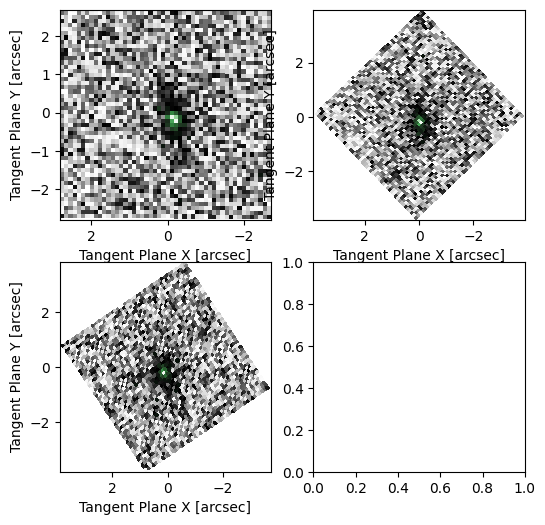

In [28]:
n = len(targets.image_list)
side = int(np.sqrt(n)) + 1
fig, ax = plt.subplots(side, side, figsize=(3 * side, 3 * side))

for i in range(n):
    ap.plots.target_image(fig, ax.ravel()[i], targets[i], window=windows[i], flipx=True)

plt.show()

The coordinate axes are in arcseconds, but in the local relative coordinate system for each image.  AstroPhot used the pixel scale to translate pixels -> arcsec.

Translate SN and host positions to projection plane positions for target.  By construction of our targets, this is in the same projection plane position.

In [29]:
sn_xy = targets[0].world_to_plane(sn["ra"], sn["dec"])
host_xy = targets[0].world_to_plane(host["ra"], host["dec"])

### Plotting Convenience Function

In [30]:
# We divide up because "model_image" expects a single axis object if single image
# while it wants an array of axis objects if there are multiple images in the image list
# model_image will not accept a one-element array if there is no image_list
def plot_target_model(model, **kwargs):
    if hasattr(model.target, "image_list"):
        _plot_target_model_multiple(model, **kwargs)
    else:
        _plot_target_model_single(model, **kwargs)


def _plot_target_model_multiple(
    model,
    window=None,
    titles=None,
    base_figsize=(12, 4),
    figsize=None,
    plot_filename=None,
):
    n = len(model.target.image_list)
    if figsize is None:
        figsize = (base_figsize[0], n * base_figsize[1])
    fig, ax = plt.subplots(n, 3, figsize=figsize)
    # Would like to just call this, but window isn't parsed as a list
    # https://github.com/Autostronomy/AstroPhot/issues/142
    #    ap.plots.target_image(fig, ax[:, 0], model.target, window=window, flipx=True)
    for axt, mod, win in zip(ax[:, 0], model.target.image_list, window):
        ap.plots.target_image(fig, axt, mod, win, flipx=True)

    if titles is not None:
        for i, title in enumerate(titles):
            ax[i, 0].set_title(title)
    ap.plots.model_image(fig, ax[:, 1], model, window=window, flipx=True)
    ax[0, 1].set_title("Model")
    ap.plots.residual_image(fig, ax[:, 2], model, window=window, flipx=True)
    ax[0, 2].set_title("Residual")
    plt.show()
    if plot_filename is not None:
        plt.savefig(plot_filename)


def _plot_target_model_single(model, window=None, title=None, figsize=(16, 4)):
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ap.plots.target_image(fig, ax[0], model.target, window=window, flipx=True)
    ax[0].set_title(title)
    ap.plots.model_image(fig, ax[1], model, window=window, flipx=True)
    ax[1].set_title("Model")
    ap.plots.residual_image(fig, ax[2], model, window=window, flipx=True)
    ax[2].set_title("Residual")
    plt.show()

### Jointly fit model across images

In [31]:
model_sky = []
model_host = []
model_sn = []

# The DC2 images are calibrated exposures that have the sky subtracted
# The RomanSN images are "raw" science images with sky.
FIT_SKY = {"DC2": False, "RomanSN": True}
FIT_HOST = True
FIT_SN = True
CORRECT_SIP = True

if FIT_SKY[DATASET]:
    for i, (target, window) in enumerate(zip(targets, windows)):
        model_sky.append(
            ap.models.AstroPhot_Model(
                name=f"sky model {i}",
                model_type="flat sky model",
                target=target,
                window=window,
            )
        )
    
if FIT_HOST:
    model_host_band = {}
    for i, (b, target, window) in enumerate(zip(band, targets, windows)):
        model_host.append(
            ap.models.AstroPhot_Model(
                name=f"host model {i}",
                model_type="sersic galaxy model",
                target=target,
                psf_mode="full",
                parameters={"center": host_xy},
                window=window,
            )
        )
        # I think this assignment copies reference that points to same underlying object
        # in 'model_host' and 'model_host_band'
        # The initialization step assumes that the reference model gets initialized first.
        # So we just mark use the first model in the list of each band.
        if b not in model_host_band.keys():
            model_host_band[b] = i  
        
if FIT_SN:
    for i, (ls, target, window) in enumerate(zip(live_sn, targets, windows)):
        if not ls:
            continue
        model_sn.append(
            ap.models.AstroPhot_Model(
                name=f"SN model {i}",
                model_type="point model",
                psf=target.psf,
                target=target,
                parameters={"center": sn_xy},
                window=window,
            )
        )

In [32]:
# AstroPhot doesn't handle SIP WCS yet.
# We'll roughly work around this by allowing a small shift in position
# for all (both) objects on the image.
CORRECT_SIP = True
if CORRECT_SIP:
    def calc_center(params):
        return params["nominal_center"].value + params["astrometric"].value

    if FIT_HOST and FIT_SN:
        host_center = ap.param.Parameter_Node(
            name = "nominal_center",
            value = host_xy    
        )

        sn_center = ap.param.Parameter_Node(
            name = "nominal_center",
            value = sn_xy
        )
            
        i = -1
        for ls in (live_sn):
            # Require that we have the SN
            # because we need both Host and SN to do a joint astrometric off set fit
            if not ls:
                continue
            i += 1
            # The x, y delta is the same for both the SN and host
            # but can be different for each image.
            P_astrometric = ap.param.Parameter_Node(
                name = "astrometric",
                value = [0, 0],
            )

            model_host[i]["center"].value = calc_center
            model_host[i]["center"].link(host_center, P_astrometric)
            
            model_sn[i]["center"].value = calc_center
            model_sn[i]["center"].link(sn_center, P_astrometric)
else:
    for b, model in zip(band, model_host):
        if model.name == model_host[model_host_band[b]].name:
            continue
        for parameter in ["center"]:
            model[parameter].value = model_host[model_host_band[b]][parameter]
    for b, model in zip(band, model_sn):
        if model.name == model_sn[model_host_band[b]].name:
            continue
        for parameter in ["center"]:
            model[parameter].value = model_host[model_host_band[b]][parameter]

Constrain host model to be the same per band

In [33]:
for b, model in zip(band, model_host):
    if model.name == model_host[model_host_band[b]].name:
        continue
    for parameter in ["q", "PA", "n", "Re", "Ie"]:
        model[parameter].value = model_host[model_host_band[b]][parameter]

In [34]:
# Create a two-tier hierarchy of group models
# following recommendation from Connor Stone.

# Group model for each class: sky, host, sn
all_model_list = []
if len(model_sky) > 0:
    sky_group_model = ap.models.AstroPhot_Model(
        name="Sky",
        model_type="group model",
        models=[*model_sky],
        target=targets,
    )
    all_model_list.extend(sky_group_model)

if len(model_host) > 0:
    host_group_model = ap.models.AstroPhot_Model(
        name="Host",
        model_type="group model",
        models=[*model_host],
        target=targets,
    )
    all_model_list.extend(host_group_model)

if len(model_sn) > 0:
    sn_group_model = ap.models.AstroPhot_Model(
        name="SN",
        model_type="group model",
        models=[*model_sn],
        target=targets,
    )
    all_model_list.extend(sn_group_model)

# Group model holds all the classes
model_host_sn = ap.models.AstroPhot_Model(
    name="Host+SN",
    model_type="group model",
    models=all_model_list,
    target=targets,
)

We have to initialize the model so that there is a value for `parameters["center"]`

In [35]:
model_host_sn.initialize()

[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


In [36]:
print(model_host_sn.parameters)

Host+SN:
center: [0.05510292289012364, -0.05396863520047068] +- 0.0 [arcsec], locked
F: 3.95567591257003 +- 0.01029535910528397 [log10(flux/arcsec^2)]
center: [-0.0021718334983187315, 0.07751632729576308] +- 0.0 [arcsec], locked
F: 3.986711285975143 +- 0.009243013178312281 [log10(flux/arcsec^2)]
center: [0.07555409862205575, 0.015508832252671967] +- 0.0 [arcsec], locked
F: 4.049356955447892 +- 0.00829775211470653 [log10(flux/arcsec^2)]
nominal_center: [-2.8614908360189056e-06, 6.0429980442404754e-05] [none]
astrometric: [0.0, 0.0] [none]
q: 0.8499999999999999 +- 0.03 [b/a], limits: (0.0, 1.0)
PA: 2.705403430240125 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
n: 0.8210242552384153 +- 0.05 [none], limits: (0.36, 8.0)
Re: 0.5356957013890087 +- 4.0430632349280575 [arcsec], limits: (0.0, None)
Ie: 3.0929709766470914 +- 0.45392133130172324 [log10(flux/arcsec^2)]
astrometric: [0.0, 0.0] [none]
center: [-2.8614908360189056e-06, 6.0429980442404754e-05] +- [0.1, 0.1] [arcsec]
nomi

In [37]:
result = ap.fit.LM(model_host_sn, verbose=True).fit()
print(result.message)

Chi^2/DoF: 4.001867064264664, L: 1.0
Chi^2/DoF: 2.7107628953185157, L: 0.3333333333333333
Chi^2/DoF: 2.505547271631862, L: 0.5555555555555555
Chi^2/DoF: 2.4626188739253516, L: 0.9259259259259257
Chi^2/DoF: 2.4499462271789954, L: 1.5432098765432096
Chi^2/DoF: 2.379218429492601, L: 0.5144032921810698
Chi^2/DoF: 2.358289823760508, L: 0.857338820301783
Chi^2/DoF: 2.283354857887851, L: 0.285779606767261
Chi^2/DoF: 2.2420668396351227, L: 0.09525986892242033
Chi^2/DoF: 2.23822096941617, L: 0.03175328964080678
Chi^2/DoF: 2.234862552980024, L: 0.010584429880268927
Chi^2/DoF: 2.2340282743803024, L: 0.01764071646711488
Chi^2/DoF: 2.233926132998937, L: 0.7350298527964533
Chi^2/DoF: 2.233881044429044, L: 1.2250497546607555
Chi^2/DoF: 2.2337706933575707, L: 0.40834991822025185
Chi^2/DoF: 2.233746993113521, L: 0.6805831970337531
Chi^2/DoF: 2.2337390374387063, L: 1.1343053283895885
Chi^2/DoF: 2.233736224931793, L: 1.8905088806493142
Chi^2/DoF: 2.233733536573392, L: 0.6301696268831047
Chi^2/DoF: 2.2337

In [38]:
print(result.model.parameters)

Host+SN:
center: [0.05510292289012364, -0.05396863520047068] +- 0.0 [arcsec], locked
F: 3.9438692276315406 +- 0.01029535910528397 [log10(flux/arcsec^2)]
center: [-0.0021718334983187315, 0.07751632729576308] +- 0.0 [arcsec], locked
F: 3.973728422796702 +- 0.009243013178312281 [log10(flux/arcsec^2)]
center: [0.07555409862205575, 0.015508832252671967] +- 0.0 [arcsec], locked
F: 4.038214952567086 +- 0.00829775211470653 [log10(flux/arcsec^2)]
nominal_center: [-0.1473947962179745, -0.10378585338771344] [none]
astrometric: [-0.027221777347704357, -0.0780907674650682] [none]
q: 0.48778824920701597 +- 0.03 [b/a], limits: (0.0, 1.0)
PA: 2.9932895345143375 +- 0.06 [radians], limits: (0.0, 3.141592653589793), cyclic
n: 3.841337314362209 +- 0.05 [none], limits: (0.36, 8.0)
Re: 1.1570513176456259 +- 4.0430632349280575 [arcsec], limits: (0.0, None)
Ie: 2.7365779592162935 +- 0.45392133130172324 [log10(flux/arcsec^2)]
astrometric: [0.11893007150594102, -0.10724447027862652] [none]
center: [0.1183068920

The uncertainties above aren't actually particularly real uncertainties.  They're from the initial uncertainty set when initializing the object.  To update the uncertainty, we can use the coraviance matrix.  We'll just take the diagonal for now.

But there could be noticeable off-diagonal elements. E.g., the flux estimates are [anti]correlated with the galaxy estimate.

In [39]:
result.update_uncertainty()

The uncertainties for the center positions and astrometric uncertainties aren't calculated correctly right now.

But the flux uncertainties are reasonable.

In [40]:
print(result.model.parameters)

Host+SN:
center: [0.05510292289012364, -0.05396863520047068] +- 0.0 [arcsec], locked
F: 3.9438692276315406 +- 0.0012147700733332212 [log10(flux/arcsec^2)]
center: [-0.0021718334983187315, 0.07751632729576308] +- 0.0 [arcsec], locked
F: 3.973728422796702 +- 0.001163097147315133 [log10(flux/arcsec^2)]
center: [0.07555409862205575, 0.015508832252671967] +- 0.0 [arcsec], locked
F: 4.038214952567086 +- 0.0010395351076414744 [log10(flux/arcsec^2)]
nominal_center: [-0.1473947962179745, -0.10378585338771344] +- [302993.8549893965, 524800.7512227923] [none]
astrometric: [-0.027221777347704357, -0.0780907674650682] +- [302993.8549893965, 524800.7512227923] [none]
q: 0.48778824920701597 +- 0.027938085713922964 [b/a], limits: (0.0, 1.0)
PA: 2.9932895345143375 +- 0.036026926682902145 [radians], limits: (0.0, 3.141592653589793), cyclic
n: 3.841337314362209 +- 0.7714426846780971 [none], limits: (0.36, 8.0)
Re: 1.1570513176456259 +- 0.3536350939409537 [arcsec], limits: (0.0, None)
Ie: 2.73657795921629

In [41]:
model_filename = f"SN_{sn_id}_AstroPhot_model.yaml"
result.model.save(model_filename)

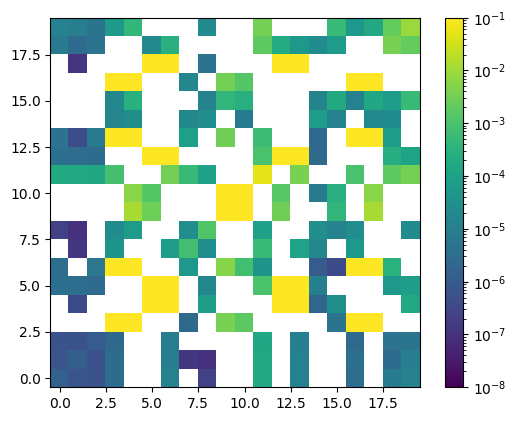

In [42]:
covar = result.covariance_matrix.detach().cpu().numpy()
plt.imshow(
    covar,
    origin="lower",
    vmin=1e-8, vmax=1e-1, norm="log",
)
plt.colorbar()

Let's focus on the SN flux uncertainties:

This is a little clunky because I don't have a better way of looking up the names of the parameters in the covariance matrix.

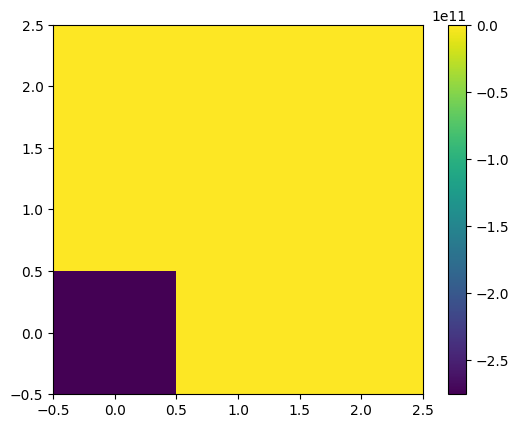

In [43]:
sn_flux_starts_at_parameter_idx = -len(targets.image_list)
covar = result.covariance_matrix.detach().cpu().numpy()
plt.imshow(
    covar[sn_flux_starts_at_parameter_idx:, sn_flux_starts_at_parameter_idx:],
    origin="lower",
#    vmin=1e-6, vmax=1, norm="log",
)
plt.colorbar()

In [44]:
sn_model_name_regex = re.compile("SN model [0-9]+")
sn_model_names = [k for k in model_host_sn.models.keys() if sn_model_name_regex.match(k)]

In [45]:
filenames = [model_host_sn.models[m].target.header.filename for m in sn_model_names]
bands = [model_host_sn.models[m].target.header.band for m in sn_model_names]
visits = [model_host_sn.models[m].target.header.visit for m in sn_model_names]
mjds = [model_host_sn.models[m].target.header.mjd for m in sn_model_names]

zp = np.array(
    [
        model_host_sn.models[m].target.zeropoint.detach().cpu().numpy()
        for m in sn_model_names
    ]
)
inst_mag = np.array(
    [
        -2.5 * model_host_sn.models[m].parameters["flux"].value.detach().cpu().numpy()
        for m in sn_model_names
    ]
)
mag_err = np.array(
    [
        2.5
        * model_host_sn.models[m].parameters["flux"].uncertainty.detach().cpu().numpy()
        for m in sn_model_names
    ]
)

In [46]:
lightcurve_obs = Table(
    {
        "filename": filenames,
        "band": bands,
        "visit": visits,
        "mjd": mjds,
        "zp": zp,
        "inst_mag": inst_mag,
        "mag_err": mag_err,
    }
)

In [47]:
lightcurve_obs["mag"] = lightcurve_obs["inst_mag"] + lightcurve_obs["zp"] 
lightcurve_obs["inst_flux"] = 10 ** (-0.4 * lightcurve_obs["inst_mag"])
lightcurve_obs["inst_flux_err"] = (np.log(10) / 2.5) * (lightcurve_obs["inst_flux"] * mag_err)

lightcurve_obs["snr"] = lightcurve_obs["inst_flux"] / lightcurve_obs["inst_flux_err"]

In [48]:
zp_AB_to_nJy = 8.90 + 2.5 * 9

lightcurve_obs["flux"] = 10 ** (-0.4 * (lightcurve_obs["mag"] - zp_AB_to_nJy))
lightcurve_obs["flux_err"] = (lightcurve_obs["flux"] / lightcurve_obs["inst_flux"]) * lightcurve_obs[
    "inst_flux_err"
]

In [49]:
lightcurve_obs["mjd"].info.format = "<10.3f"
lightcurve_obs["zp"].info.format = ">7.4f"
lightcurve_obs["flux"].info.format=".3e"
lightcurve_obs["flux_err"].info.format=".3e"
lightcurve_obs["snr"].info.format="0.2f"
lightcurve_obs["mag"].info.format = ">7.4f"
lightcurve_obs["mag_err"].info.format = ">7.4f"

In [50]:
lightcurve_obs

filename,band,visit,mjd,zp,inst_mag,mag_err,mag,inst_flux,inst_flux_err,snr,flux,flux_err
str43,str1,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
data/RomanSN/rotate_update_Y106_160_10.fits,Y,55230,55230.000,32.6030,-6.924605250826711,0.1523,25.6784,588.6296040102685,82.57500882966275,7.13,1.944e+02,2.727e+01
data/RomanSN/rotate_update_Y106_170_1.fits,Y,55280,55280.000,32.6030,-6.447356001737025,0.2329,26.1556,379.26468078673565,81.35176784435711,4.66,1.252e+02,2.686e+01


In [51]:
lightcurve_truth

MJD,BAND,CCDNUM,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,PSF_RATIO,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,SIM_MAGOBS,SIM_FLUXCAL_HOSTERR,flux,mag,band,visit
float64,str2,int16,str12,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str2,int64
55205.0,Y,-9,DEEP,0,-9.0,0.16242194,0.652476,0.711,0.0,0.0,11.87,0.0,8.33,32.603,0.001,1.0,99.0,0.0,9.12013e-28,99.0,Y,55205
55205.0043,J,-9,DEEP,0,-9.0,-0.8886157,0.82833904,0.767,0.0,0.0,11.49,0.0,8.33,32.543,0.001,1.0,99.0,0.0,9.12013e-28,99.0,J,55205
55205.0086,H,-9,DEEP,0,-9.0,-0.6534423,0.97780824,0.891,0.0,0.0,11.62,0.0,8.33,32.603,0.001,1.0,99.0,0.0,9.12013e-28,99.0,H,55205
55205.0128,F,-9,DEEP,0,-9.0,-0.035991684,0.8290506,0.99,0.0,0.0,19.9,0.0,6.32,33.346,0.001,1.0,99.0,0.0,9.12013e-28,99.0,F,55205
55210.0,Y,-9,DEEP,0,-9.0,0.638226,0.65578383,0.711,0.0,0.0,11.87,0.0,8.33,32.603,0.001,1.0,99.0,0.0,9.12013e-28,99.0,Y,55210
55210.0043,J,-9,DEEP,0,-9.0,-0.7288856,0.82833904,0.767,0.0,0.0,11.49,0.0,8.33,32.543,0.001,1.0,99.0,0.0,9.12013e-28,99.0,J,55210
55210.0086,H,-9,DEEP,0,-9.0,-0.48966235,0.97780824,0.891,0.0,0.0,11.62,0.0,8.33,32.603,0.001,1.0,99.0,0.0,9.12013e-28,99.0,H,55210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55390.0,Y,-9,DEEP,0,-9.0,-0.4206794,0.65134305,0.711,0.0,0.0,11.87,0.0,8.33,32.603,0.001,1.0,28.848345,0.0,10.487258,28.848345,Y,55390


In [52]:
from astropy.table import join

lightcurve = join(
    lightcurve_truth,
    lightcurve_obs[
        [
            "filename",
            "visit",
            "band",
            "mjd",
            "zp",
            "inst_mag",
            "mag_err",
            "mag",
            "inst_flux",
            "inst_flux_err",
            "snr",
            "flux",
            "flux_err",
        ]
    ],
    keys_left=["visit", "band"],
    keys_right=["visit", "band"],
    join_type="left",
    table_names=("truth", "obs"),
)

In [53]:
lightcurve

MJD,BAND,CCDNUM,FIELD,PHOTFLAG,PHOTPROB,FLUXCAL,FLUXCALERR,PSF_SIG1,PSF_SIG2,PSF_RATIO,SKY_SIG,SKY_SIG_T,RDNOISE,ZEROPT,ZEROPT_ERR,GAIN,SIM_MAGOBS,SIM_FLUXCAL_HOSTERR,flux_truth,mag_truth,band_truth,visit_truth,filename,visit_obs,band_obs,mjd,zp,inst_mag,mag_err,mag_obs,inst_flux,inst_flux_err,snr,flux_obs,flux_err
float64,str2,int16,str12,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,str2,int64,str43,int64,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
55205.0128,F,-9,DEEP,0,-9.0,-0.035991684,0.8290506,0.99,0.0,0.0,19.9,0.0,6.32,33.346,0.001,1.0,99.0,0.0,9.12013e-28,99.0,F,55205,--,--,--,--,--,--,--,--,--,--,--,--,--
55205.0086,H,-9,DEEP,0,-9.0,-0.6534423,0.97780824,0.891,0.0,0.0,11.62,0.0,8.33,32.603,0.001,1.0,99.0,0.0,9.12013e-28,99.0,H,55205,--,--,--,--,--,--,--,--,--,--,--,--,--
55205.0043,J,-9,DEEP,0,-9.0,-0.8886157,0.82833904,0.767,0.0,0.0,11.49,0.0,8.33,32.543,0.001,1.0,99.0,0.0,9.12013e-28,99.0,J,55205,--,--,--,--,--,--,--,--,--,--,--,--,--
55205.0,Y,-9,DEEP,0,-9.0,0.16242194,0.652476,0.711,0.0,0.0,11.87,0.0,8.33,32.603,0.001,1.0,99.0,0.0,9.12013e-28,99.0,Y,55205,--,--,--,--,--,--,--,--,--,--,--,--,--
55210.0128,F,-9,DEEP,0,-9.0,-0.89903015,0.8290506,0.99,0.0,0.0,19.9,0.0,6.32,33.346,0.001,1.0,99.0,0.0,9.12013e-28,99.0,F,55210,--,--,--,--,--,--,--,--,--,--,--,--,--
55210.0086,H,-9,DEEP,0,-9.0,-0.48966235,0.97780824,0.891,0.0,0.0,11.62,0.0,8.33,32.603,0.001,1.0,99.0,0.0,9.12013e-28,99.0,H,55210,--,--,--,--,--,--,--,--,--,--,--,--,--
55210.0043,J,-9,DEEP,0,-9.0,-0.7288856,0.82833904,0.767,0.0,0.0,11.49,0.0,8.33,32.543,0.001,1.0,99.0,0.0,9.12013e-28,99.0,J,55210,--,--,--,--,--,--,--,--,--,--,--,--,--
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55390.0128,F,-9,DEEP,0,-9.0,0.5859871,0.8306704,0.99,0.0,0.0,19.9,0.0,6.32,33.346,0.001,1.0,28.255508,0.0,18.104916,28.255508,F,55390,--,--,--,--,--,--,--,--,--,--,--,--,--


In [54]:
if DATASET == "DC2":
    lightcurve["band"] = lightcurve["bandpass"]
if DATASET == "RomanSN":
    lightcurve["band"] = lightcurve["BAND"]

In [55]:
color_for_band = {
    "u": "purple",
    "g": "blue",
    "r": "green",
    "i": "red",
    "z": "black",
    "y": "yellow",
    "Y": "blue",
    "J": "green",
    "H": "red",
    "F": "black",
    "Y106": "blue",
}

/usr/local/lib/python3.11/site-packages/matplotlib/axes/_base.py:2503: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


(55195.49957, 55404.50903)

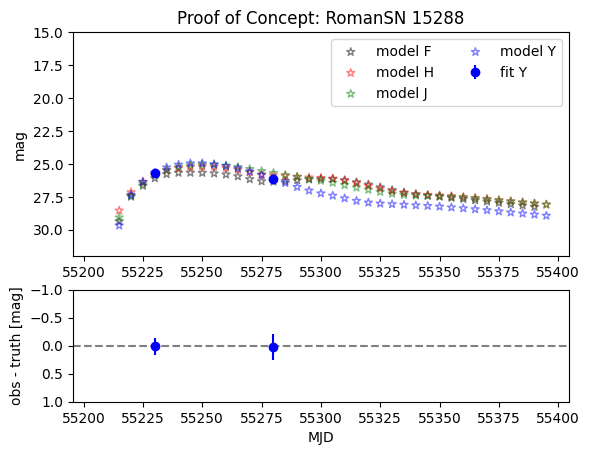

In [56]:
_, axes = plt.subplots(2, 1, height_ratios=[2, 1])

ax = axes[0]
# Don't print non-detections until we switch to flux fitting
snr_threshold = 3
for b in np.unique(lightcurve_obs["band"]):
    (idx,) = np.where(
        (lightcurve_obs["band"] == b) & (lightcurve_obs["snr"] > snr_threshold)
    )
    ax.errorbar(
        lightcurve_obs[idx]["mjd"],
        lightcurve_obs[idx]["mag"],
        lightcurve_obs[idx]["mag_err"],
        marker="o",
        markerfacecolor=color_for_band[b],
        markeredgecolor=color_for_band[b],
        ecolor=color_for_band[b],
        linestyle="none",
        label=f"fit {b}",
    )
ax.set_ylabel("mag")
# ax.set_xlabel("MJD")
ax.set_title(f"Proof of Concept: {DATASET} {sn_id}")
# plt.ylim(23.5, 17)


if lightcurve_truth is not None:
    for b in np.unique(lightcurve_truth["band"]):
        (idx,) = np.where(lightcurve_truth["band"] == b)
        ax.scatter(
            lightcurve_truth[idx]["MJD"],
            lightcurve_truth[idx]["mag"],
            edgecolor=color_for_band[b],
            facecolor="none",
            alpha=0.5,
            marker="*",
            label=f"model {b}",
        )

ax.set_ylim(ax.get_ylim()[::-1]);
if DATASET == "RomanSN":
    ax.set_ylim(32, 15)

ax.legend(ncols=2)

###
ax = axes[1]

for b in np.unique(lightcurve["band"]):
    (idx,) = np.where(
        (lightcurve["band"] == b)
    )
    ax.errorbar(
        lightcurve[idx]["mjd"],
        lightcurve[idx]["mag_obs"] - lightcurve[idx]["mag_truth"],
        lightcurve[idx]["mag_err"],
        marker="o",
        markerfacecolor=color_for_band[b],
        markeredgecolor=color_for_band[b],
        ecolor=color_for_band[b],
        linestyle="none",
        label=f"{b}",
    )
ax.set_ylabel("obs - truth [mag]")
ax.set_xlabel("MJD")
# plt.ylim(23.5, 17)
ax.axhline(0, color="gray", ls="--")
ax.set_ylim(1, -1)
ax.set_xlim(axes[0].get_xlim())


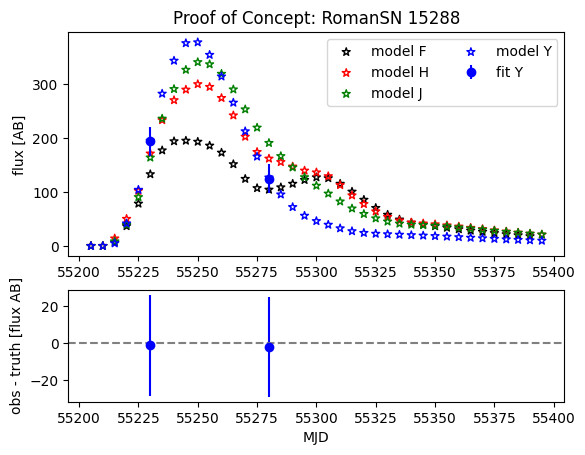

In [57]:
_, axes = plt.subplots(2, 1, height_ratios=[2, 1])

ax = axes[0]
for b in np.unique(lightcurve_obs["band"]):
    (idx,) = np.where(
        (lightcurve_obs["band"] == b)
    )
    ax.errorbar(
        lightcurve_obs[idx]["mjd"],
        lightcurve_obs[idx]["flux"],
        lightcurve_obs[idx]["flux_err"],
        marker="o",
        markerfacecolor=color_for_band[b],
        markeredgecolor=color_for_band[b],
        ecolor=color_for_band[b],
        linestyle="none",
        label=f"fit {b}",
    )
ax.set_ylabel("flux [AB]")
# ax.set_xlabel("MJD")
ax.set_title(f"Proof of Concept: {DATASET} {sn_id}")


if lightcurve_truth is not None:
    for b in np.unique(lightcurve_truth["band"]):
        (idx,) = np.where(lightcurve_truth["band"] == b)
        ax.scatter(
            lightcurve_truth[idx]["MJD"],
            lightcurve_truth[idx]["flux"],
            edgecolor=color_for_band[b],
            facecolor="none",
            marker="*",
            label=f"model {b}",
        )

ax.legend(ncols=2)

###
ax = axes[1]

for b in np.unique(lightcurve["band"]):
    (idx,) = np.where(
        (lightcurve["band"] == b)
    )
    ax.errorbar(
        lightcurve[idx]["mjd"],
        lightcurve[idx]["flux_obs"] - lightcurve[idx]["flux_truth"],
        lightcurve[idx]["flux_err"],
        marker="o",
        markerfacecolor=color_for_band[b],
        markeredgecolor=color_for_band[b],
        ecolor=color_for_band[b],
        linestyle="none",
        label=f"{b}",
    )
ax.set_ylabel("obs - truth [flux AB]")
ax.set_xlabel("MJD")
ax.axhline(0, color="gray", ls="--")
ax.set_xlim(axes[0].get_xlim());     


The agreement is pretty good for DC2 11392192729110, but somewhat less good for DC2 41021613806.  I speculate the remaining offset is due to aperture correction between the PSF and calibration zeropoint.  The current spread in values during a night is a very loose guide to the amount we need to improve in extracting the lightcurve in this Notebook.

The agreement is excellent for RomanSN 15288, although it's just two SN LC points.

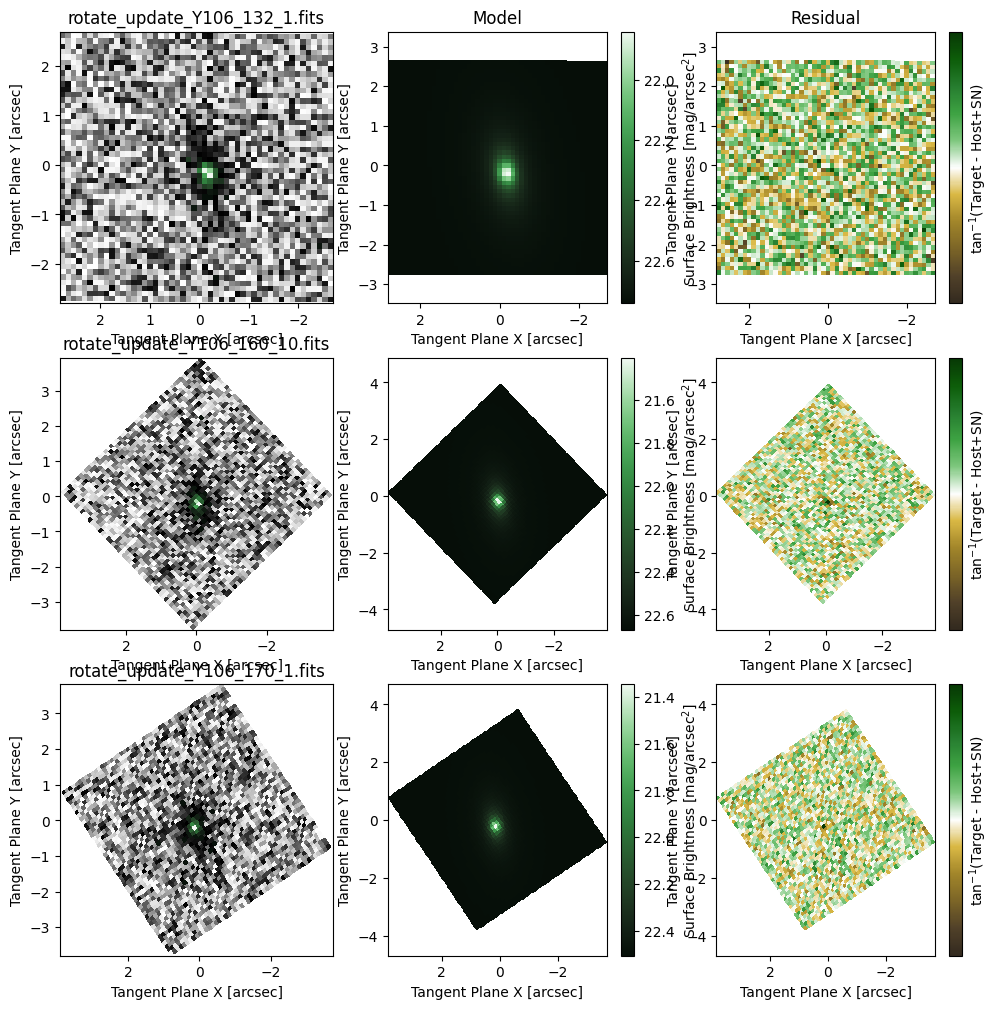

<Figure size 640x480 with 0 Axes>

In [58]:
plot_target_model(
    model_host_sn,
    window=windows,
    titles=image_file_basenames,
    plot_filename=f"sn_{DATASET}_{sn_id}_model.png",
)